In [1]:
import json
import os
import music21 as mc

PATH_DATA = '../data'
PATH_DATA_INTERIM = os.path.join(PATH_DATA, 'interim')
FILENAME = "parsed.json"

with open(os.path.join(PATH_DATA_INTERIM, FILENAME), "r") as handle:
    parsed = json.load(handle)
    
parsed.keys()

dict_keys(['notes', 'chords', 'parse_success', 'parse_failures', 'mode', 'beats_in_measure', 'artist', 'songpart', 'info'])

In [2]:
len(parsed['parse_success'])

19866

In [3]:
notes_only_idx = []
chords_only_idx = []
nothing = []
OK_idx = []
too_short = []

durations = []
MIN_DURATION = 16.0

for idx, notes, chords in zip(
    range(len(parsed['notes'])),
    parsed['notes'],
    parsed['chords'],
):
    if any("None" in ch for ch in chords):
        notes_only_idx.append(idx)
    elif len(notes) == 0:
        chords_only_idx.append(idx)
    elif len(notes) == 0 and any("None" in ch for ch in chords):
        nothing.append(idx)
    else:
        song_duration = sum(float(n.split('_')[-1]) for n in parsed['notes'][idx])
        durations.append(song_duration)
        if song_duration < MIN_DURATION:
            too_short.append(idx)
        else:
            OK_idx.append(idx)

len(notes_only_idx), len(chords_only_idx), len(nothing), len(too_short), len(OK_idx)

(367, 1683, 0, 163, 17653)

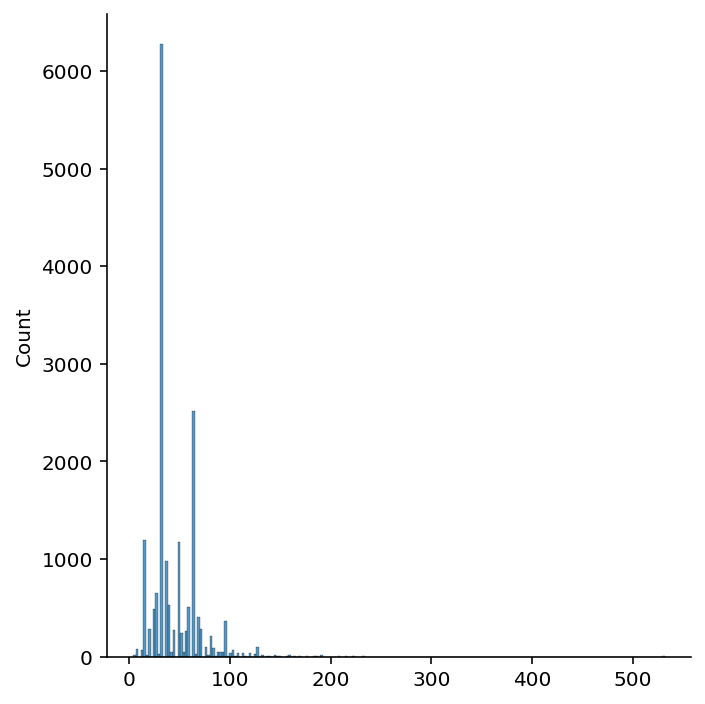

In [4]:
import seaborn as sns

sns.displot(durations)

In [6]:
len(chords_only_idx) / len(OK_idx)

0.09533790290602163

In [7]:
import os, sys, inspect
sys.path.insert(0, "/Users/jells_b/Dev/Chord-based_Melody_Generation/notebooks 2") 

import data_utils
import models
import chord_utils

import random
import json
from keras import backend as K

SEED = 14141414
models.set_seed(SEED)

SEED: 13111996
python 3.8.7 (default, Jan 10 2021, 15:32:30) 
[Clang 12.0.0 (clang-1200.0.32.28)]
keras version 2.4.0
tensorflow version 2.4.1
SEED: 14141414
python 3.8.7 (default, Jan 10 2021, 15:32:30) 
[Clang 12.0.0 (clang-1200.0.32.28)]
keras version 2.4.0
tensorflow version 2.4.1


In [8]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(OK_idx, test_size=0.1, random_state=SEED)
train_idx, validation_idx = train_test_split(OK_idx, test_size=0.2, random_state=SEED)

len(train_idx), len(validation_idx), len(test_idx)+len(chords_only_idx)

(14122, 3531, 3449)

In [9]:
with open(os.path.join(PATH_DATA_INTERIM, "train_val_test_split.json"), "w") as handle:
    json.dump({
        "train": train_idx,
        "val": validation_idx,
        "test": test_idx
    }, handle)

In [11]:
train_notes, train_chords, train_modes, train_bim, train_keys = (
    [parsed[key][idx] for idx in train_idx]
    for key in ['notes', 'chords', 'mode', 'beats_in_measure', 'parse_success']
)

chord_names_dict = {}
train_chords_commonnames = [
    [
        chord_names_dict[ch] + "_" + ch.split('_')[-1] if ch in chord_names_dict 
        else chord_names_dict.setdefault(
            ch, 
            (
                mc.chord.Chord(ch.split('_')[0].split('.')).pitchedCommonName.replace('-', ' ')
                if not any(piece in ch for piece in ["BEGIN", "END"])
                else ch.split('_')[0]
            )
        ) + "_" + ch.split('_')[-1]
        for ch in ["BEGIN_0.0", *chs, "END_0.0"]
    ]
    for chs in train_chords
]

note_names_dict = {}
def unify_note(name_with_octave):
    if name_with_octave in note_names_dict:
        return note_names_dict[name_with_octave]
    elif name_with_octave in ["BEGIN", "REST", "END"]:
        return name_with_octave
    else:
        p = mc.note.Note(name_with_octave).pitch.ps
        return note_names_dict.setdefault(
            name_with_octave, 
            mc.note.Note(p).nameWithOctave
        )

train_notes_commonnames = [
    [
        unify_note(n.split('_')[0]) + "_" + n.split('_')[-1]
        for n in ["BEGIN_0.0", *ns, "END_0.0"]
    ]
    for ns in train_notes
]

In [15]:
from functools import lru_cache

@lru_cache
def float_c(x):
    return float(x)

@lru_cache
def notes_transform(x):
    return notes_vectorizer.transform(x)

In [169]:
chord_name_vectorizer = chord_utils.get_chords_CountVectorizer(
    train_chords_commonnames,
    count_vectorizer_kwargs={
        "lowercase": False,
        "preprocessor":lambda x : x.split('_')[0], 
        "tokenizer": lambda x : x.split(),
        "min_df": 1e-3
    }
)

/Users/jells_b/.virtualenvs/Chord-based_Melody_Generation/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Created vocabulary: 
{'START': 14, 'BEGIN': 2, 'C': 4, 'major': 24, 'triad': 35, 'D': 6, 'minor': 25, 'F': 10, 'Bb': 3, 'END': 8, 'A': 0, 'G': 12, 'E': 7, 'F#': 11, 'half': 22, 'diminished': 17, 'seventh': 31, 'chord': 16, 'G#': 13, 'quartal': 29, 'trichord': 36, 'Eb': 9, 'enharmonic': 19, 'equivalent': 20, 'to': 34, 'above': 15, 'second': 30, 'tetrachord': 32, 'pentachord': 26, 'dominant': 18, 'B': 1, 'tetramirror': 33, 'C#': 5, 'perfect': 27, 'fourth': 21, 'lydian': 23, 'tritone': 37, 'phrygian': 28}


In [170]:
chord_words = [ccc for chords in train_chords_commonnames for ch in chords for ccc in ch.split('_')[0].split(' ')]
from collections import Counter
Counter(chord_words).most_common(10)

[('triad', 170211),
 ('major', 126386),
 ('minor', 74257),
 ('A', 44393),
 ('C', 42746),
 ('F', 38657),
 ('G', 37049),
 ('seventh', 33929),
 ('chord', 33929),
 ('D', 23288)]

### Let's convert notes so that max duration is 4.0, but note can be "continued" 

In [16]:
import seaborn as sns
import numpy as np

def transform_cutduration(pieces_list, MAX_DURATION=2.0):
    durations = []
    result = []

    for pieces in pieces_list:
        new_pieces = []
        for p in pieces:
            pitch = p.split('_')[0]
            duration = float(p.split('_')[-1])
            durations.append(duration)
            if duration > MAX_DURATION:
                new_pieces.append('_'.join([pitch, str(MAX_DURATION), "START"]))
                duration -= MAX_DURATION
                while duration > MAX_DURATION:
                    new_pieces.append('_'.join([pitch, str(MAX_DURATION), "CONTINUE"]))
                    duration -= MAX_DURATION
                if duration > 0:
                    new_pieces.append('_'.join([pitch, str(duration), "CONTINUE"]))
            else:
                new_pieces.append(p + "_START")

        old_total_duration = sum(float(p.split('_')[1]) for p in pieces)
        new_total_duration = sum(float(p.split('_')[1]) for p in new_pieces)
        assert old_total_duration == new_total_duration
        result.append(new_pieces)
        
    return result

train_notes_commonnames_cutduration = transform_cutduration(train_notes_commonnames, MAX_DURATION=2.0)
train_chords_commonnames_cutduration = transform_cutduration(train_chords_commonnames, MAX_DURATION=4.0)

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

mc_note_cache = {}

@lru_cache(maxsize=1024)
def pitch_octave_note_tokenizer(x):
    result = []
    x_sp = x.split('_')
    if x_sp[0] in ['BEGIN', 'END', 'REST'] or x_sp[0][0].isdigit():
        result.append(x_sp[0])
    else:
        global mc_note_cache
        if x_sp[0] in mc_note_cache:
            n = mc_note_cache[x_sp[0]]
        else:
            n = mc_note_cache.setdefault(x_sp[0], mc.note.Note(x_sp[0]))
        result += [n.name, str(n.octave)]
    result = result + x_sp[1:]
    return result

vectorizer_kwargs = {
    "preprocessor": lambda x : x,
    "tokenizer": pitch_octave_note_tokenizer,
    "min_df": 1e-5
}

notes_vectorizer = CountVectorizer(**vectorizer_kwargs)
notes_flat = [
    n for notes in train_notes_commonnames_cutduration 
    for n in notes
]
notes_vectorizer.fit(notes_flat)

/Users/jells_b/.virtualenvs/Chord-based_Melody_Generation/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


CountVectorizer(min_df=1e-05, preprocessor=<function <lambda> at 0x132eefca0>,
                tokenizer=<functools._lru_cache_wrapper object at 0x1644a7af0>)

In [18]:
len(notes_vectorizer.vocabulary_), len(set(notes_flat)), 1e-5*len(notes_flat)

(33, 941, 8.66037)

In [19]:
notes_vectorizer.vocabulary_

{'BEGIN': 19,
 '0.0': 0,
 'START': 32,
 'REST': 31,
 '0.5': 2,
 'A': 16,
 '4': 12,
 'B': 17,
 'C': 20,
 '5': 13,
 'D': 23,
 'E': 24,
 'G': 29,
 '2.0': 10,
 '1.0': 5,
 'F': 27,
 'END': 26,
 '1.5': 7,
 '3': 11,
 'CONTINUE': 22,
 '0.25': 1,
 'G#': 30,
 '1.75': 8,
 '0.75': 3,
 '1.25': 6,
 '6': 14,
 'E-': 25,
 'B-': 18,
 'F#': 28,
 '2': 9,
 'C#': 21,
 '7': 15,
 '1': 4}

In [20]:
@lru_cache(maxsize=1024)
def chord_tokenizer(x):
    tokens = []
    for token in x.split('_'):
        for tt in token.split():
            tokens.append(tt)
    return tokens

vectorizer_kwargs = {
    "preprocessor": lambda x : x,
    "tokenizer": chord_tokenizer,
    "min_df": 1e-2
}

chords_vectorizer = CountVectorizer(**vectorizer_kwargs)
chords_flat = [
    ch for chords in train_chords_commonnames_cutduration 
    for ch in chords
]
chords_vectorizer.fit(chords_flat)

CountVectorizer(min_df=0.01, preprocessor=<function <lambda> at 0x1708090d0>,
                tokenizer=<functools._lru_cache_wrapper object at 0x170809280>)

In [21]:
len(chords_vectorizer.vocabulary_)

39

In [22]:
chords_vectorizer.vocabulary_

{'BEGIN': 13,
 '0.0': 0,
 'START': 23,
 'A': 11,
 'minor': 31,
 'triad': 37,
 '1.5': 5,
 '0.5': 2,
 'C': 15,
 'major': 30,
 'G': 22,
 'D': 17,
 '1.0': 4,
 'END': 19,
 'seventh': 34,
 'chord': 25,
 '4.0': 10,
 'CONTINUE': 16,
 'F': 21,
 'E': 18,
 'quartal': 32,
 'trichord': 38,
 '2.5': 7,
 '2.0': 6,
 '3.5': 9,
 'B': 12,
 'diminished': 26,
 'Bb': 14,
 '3.0': 8,
 'Eb': 20,
 'second': 33,
 'tetrachord': 35,
 'enharmonic': 28,
 'equivalent': 29,
 'to': 36,
 'above': 24,
 'dominant': 27,
 '0.25': 1,
 '0.75': 3}

In [23]:
sample_notes = train_notes_commonnames_cutduration[0]
sample_chords = train_chords_commonnames_cutduration[0]

PREV_NOTES_WINDOW = 4
PREV_CHORDS_WINDOW = 2
BATCH_SIZE = 128

X_notes = []
X_chords = []
songparts = [] #TODO
y = []

X_sample_to_song_idx = []

for idx, (sample_notes, sample_chords) in enumerate(
    zip(
        train_notes_commonnames_cutduration, 
        train_chords_commonnames_cutduration
    )
):
    if idx % 1000 == 0:
        print(idx)
        
    songname = parsed['parse_success'][train_idx[idx]]
    songpart = songname.split('/')[-1].split('_')[0].replace('.mid', '')

    note_off = 0.0
    chord_off = 0.0
    bim = float_c(parsed['beats_in_measure'][train_idx[idx]])
    chidx = 0

    sample_notes_pad = ["BEGIN_0.0_START"] * (PREV_NOTES_WINDOW-1) + sample_notes
    duration = sum(float(x.split('_')[1]) for x in sample_notes_pad)
    if duration % bim != 0.0:
        print("Duration doesn't match beats_in_measure!")
#         last_note_pitch = sample_notes_pad[-2]
#         accu = bim - duration%bim
#         print(duration, '|', bim, '|', bim - duration%bim, last_note)
#         sample_notes_pad.append(f"REST_{bim-duration%bim}_START")
        
    sample_notes_pad = sample_notes_pad + ["END_0.0_CONTINUE"]*(BATCH_SIZE-len(sample_notes_pad)%BATCH_SIZE + PREV_NOTES_WINDOW)
    
    for i in range(PREV_NOTES_WINDOW, len(sample_notes_pad)):
        X_sample_to_song_idx.append(train_idx[idx])
        
        # ____ NOTES
        notes_slice = sample_notes_pad[i-PREV_NOTES_WINDOW:i]
        X_notes.append([*notes_slice, str(note_off % bim)])
        assert len(X_notes[-1]) == PREV_NOTES_WINDOW+1
        # ____ TARGET
        target = sample_notes_pad[i]
        y.append(target)

    #     print("->", target)

        ds = [float_c(note.split('_')[1]) for note in notes_slice]
        if note_off == 0.0:
            note_off += sum(ds)

        while chord_off <= note_off and chidx < len(sample_chords):
            chord_off += float_c(sample_chords[chidx].split('_')[1])
            chidx += 1

        # ____ CURRENT CHORD
        current_chord = sample_chords[chidx-1]
        current_chord_rem = chord_off-note_off

        # ____ NEXT_CHORD
        if chidx < len(sample_chords):
            next_chord = sample_chords[chidx]
        else:
            next_chord = "END_0.0_START"

        # ____ PREVIOUS CHORD
        prev_chords = sample_chords[:chidx]
        prev_chords = prev_chords[::-1][1:PREV_CHORDS_WINDOW]
        while len(prev_chords) < PREV_CHORDS_WINDOW-1:
            prev_chords.append("BEGIN_0.0_START")
            
        X_chords.append([*prev_chords, current_chord, next_chord, str(current_chord_rem)])
        assert len(X_chords[-1]) == PREV_CHORDS_WINDOW+1+1
        
        target_d = float_c(target.split('_')[1])
        if target_d > 4.0:
            print("ERR", target)
            break
        note_off += target_d
        
    if note_off % bim != 0.0:
        print("OOPS! Dafuq?", note_off, bim)
        break
    
    assert len(X_notes) % BATCH_SIZE == 0
    assert len(X_chords) == len(X_notes) == len(y)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000


In [24]:
NOTES_PER_SAMPLE = len(X_notes[0])
X_notes_encoded = notes_vectorizer.transform([nt for notes in X_notes for nt in notes])
X_notes_encoded = np.array(
    [np.concatenate(X_notes_encoded[i:i+NOTES_PER_SAMPLE].toarray()) for i in range(0, X_notes_encoded.shape[0], NOTES_PER_SAMPLE)]
)

In [28]:
X_chords_encoded = chords_vectorizer.transform([ch for chords in X_chords for ch in chords])
CHORDS_PER_SAMPLE = len(X_chords[0])
X_chords_encoded = np.array(
    [np.concatenate(X_chords_encoded[i:i+CHORDS_PER_SAMPLE].toarray()) for i in range(0, X_chords_encoded.shape[0], CHORDS_PER_SAMPLE)]
)

In [30]:
X_notes_encoded.shape, X_chords_encoded.shape

((1908480, 165), (1908480, 156))

In [31]:
sample_notes_pad

['BEGIN_0.0_START',
 'BEGIN_0.0_START',
 'BEGIN_0.0_START',
 'BEGIN_0.0_START',
 'F4_1.5_START',
 'E4_1.5_START',
 'C4_1.0_START',
 'F4_1.5_START',
 'E4_1.5_START',
 'C4_1.0_START',
 'F4_1.5_START',
 'E4_1.5_START',
 'C4_1.0_START',
 'F4_1.5_START',
 'E4_1.5_START',
 'C4_1.0_START',
 'F4_1.5_START',
 'E4_1.5_START',
 'C4_1.0_START',
 'F4_1.5_START',
 'E4_1.5_START',
 'C4_1.0_START',
 'F4_1.5_START',
 'E4_1.5_START',
 'C4_1.0_START',
 'F4_1.5_START',
 'E4_1.5_START',
 'C4_0.5_START',
 'E4_0.5_START',
 'G4_1.0_START',
 'G4_1.0_START',
 'G4_0.5_START',
 'G4_1.0_START',
 'G4_1.0_START',
 'F4_1.0_START',
 'E4_1.0_START',
 'F4_1.0_START',
 'E4_0.5_START',
 'G4_1.0_START',
 'G4_1.0_START',
 'G4_0.5_START',
 'G4_1.0_START',
 'G4_1.0_START',
 'F4_1.0_START',
 'E4_1.0_START',
 'F4_1.0_START',
 'REST_0.5_START',
 'E4_1.5_START',
 'C4_1.5_START',
 'REST_1.0_START',
 'F4_1.0_START',
 'E4_0.5_START',
 'C4_1.5_START',
 'D4_0.5_START',
 'C4_2.0_START',
 'REST_2.0_START',
 'REST_2.0_CONTINUE',
 'REST_2

In [32]:
vectorizer_kwargs = {
    "preprocessor": lambda x : x,
    "tokenizer": pitch_octave_note_tokenizer,
    "min_df": 0.0
}

targets_vectorizer = CountVectorizer(**vectorizer_kwargs)
targets_vectorizer.fit(y)
targets_encoded = targets_vectorizer.transform(y)

import scipy
targets_encoded = scipy.sparse.csr_matrix.todense(targets_encoded)

targets_vectorizer.vocabulary_

{'REST': 31,
 '0.5': 2,
 'START': 32,
 'A': 17,
 '4': 12,
 'B': 18,
 'C': 20,
 '5': 13,
 'D': 23,
 'E': 24,
 'G': 29,
 '2.0': 10,
 '1.0': 5,
 'F': 27,
 'END': 26,
 '0.0': 0,
 'CONTINUE': 22,
 '1.5': 7,
 '3': 11,
 '0.25': 1,
 'G#': 30,
 '1.75': 8,
 '0.75': 3,
 '1.25': 6,
 '6': 14,
 'E-': 25,
 'B-': 19,
 'F#': 28,
 '2': 9,
 'C#': 21,
 '7': 15,
 '1': 4,
 '8': 16}

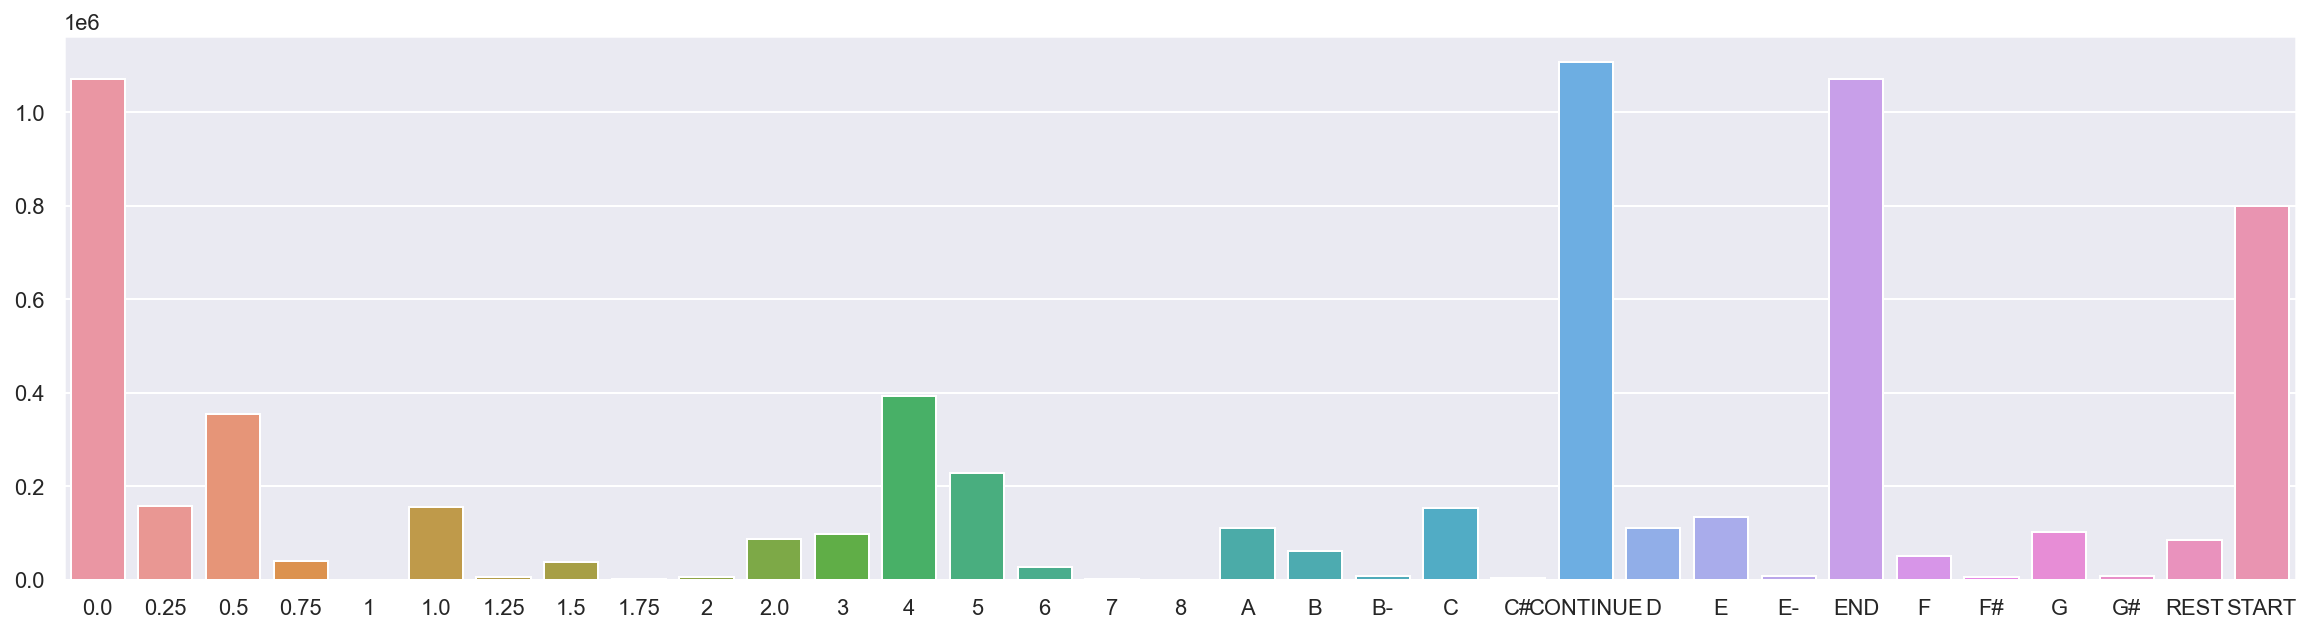

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))
ax = sns.barplot(x=targets_vectorizer.get_feature_names(), y=np.array(np.sum(targets_encoded, axis=0))[0])

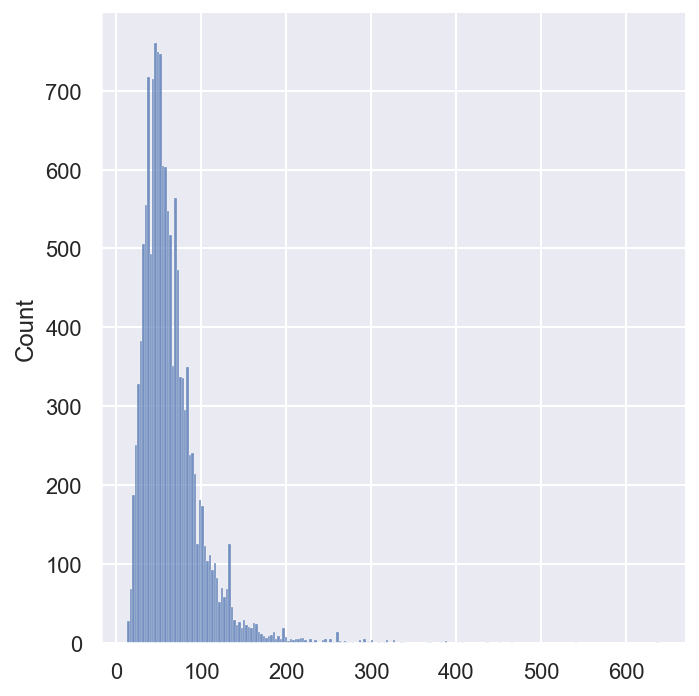

In [64]:
sample_per_song_counts = list(map(
    lambda x : x[-1],
    Counter(
        list(
            map(
                lambda x : x[-1], 
                filter(
                    lambda x : set(x[0]) != {"END_0.0_CONTINUE", '0.0'}, 
                    zip(X_notes, X_sample_to_song_idx)
                )
            )
        )
    ).most_common()
))
sns.displot(sample_per_song_counts)

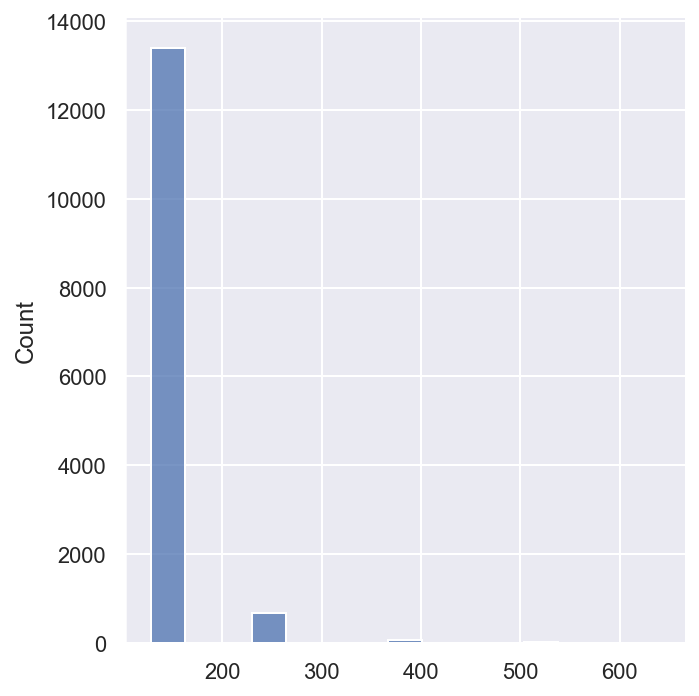

In [65]:
sample_per_song_pad_counts = list(map(lambda x : x[-1], Counter(X_sample_to_song_idx).most_common()))
sns.displot(sample_per_song_pad_counts)

In [66]:
np.mean(sample_per_song_counts), np.std(sample_per_song_counts), np.min(sample_per_song_counts), np.max(sample_per_song_counts)

(64.32537884152386, 35.73724696022651, 13, 638)

In [67]:
X_notes_encoded.shape[0] / BATCH_SIZE

14910.0

In [68]:
TIMESTEPS = 1
X_notes_input = np.reshape(X_notes_encoded, (X_notes_encoded.shape[0], 1, X_notes_encoded.shape[-1]))
X_chords_input = np.reshape(X_chords_encoded, (X_chords_encoded.shape[0], 1, X_chords_encoded.shape[-1]))
X_notes_input.shape, X_chords_input.shape

((1908480, 1, 165), (1908480, 1, 156))

In [459]:
from keras.layers import LSTM
from collections import namedtuple 

InputConfig = namedtuple('InputConfig', ['batch', 'timesteps', 'feature'])
NotesCfg = InputConfig(BATCH_SIZE, TIMESTEPS, X_notes_encoded.shape[-1])
ChordsCfg = InputConfig(BATCH_SIZE, TIMESTEPS, X_chords_encoded.shape[-1])

NotesCfg, ChordsCfg

(InputConfig(batch=16, timesteps=128, feature=165),
 InputConfig(batch=16, timesteps=128, feature=156))

In [489]:
# from sklearn import preprocessing
# import tensorflow as tf

# le = preprocessing.LabelEncoder()
# le.fit(y)
# print(len(list(le.classes_)))

# y_encoded = tf.keras.utils.to_categorical(le.transform(y))
# print(y_encoded.shape)


945
(1874304, 945)


In [69]:
Counter(y).most_common()[:10]

[('END_0.0_CONTINUE', 1056565),
 ('C4_0.5_START', 31395),
 ('E4_0.5_START', 30240),
 ('C5_0.5_START', 28376),
 ('A4_0.5_START', 25787),
 ('G4_0.5_START', 24892),
 ('D4_0.5_START', 24300),
 ('REST_0.5_START', 22686),
 ('E5_0.5_START', 19899),
 ('D5_0.5_START', 18358)]

In [103]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

model = Sequential()

model.add(LSTM(units=128, return_sequences=False, batch_input_shape=(BATCH_SIZE, TIMESTEPS, X_chords_encoded.shape[-1])))
model.add(Dropout(0.2))

model.add(Dense(units=targets_encoded.shape[-1]))

model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x=X_chords_input, y=targets_encoded, batch_size=BATCH_SIZE)#, epochs=5)

14910/14910 [==============================] - 41s 3ms/step - loss: 0.1509


In [105]:
model.predict??

In [107]:
predictions = model.predict(X_chords_input[:128], batch_size=BATCH_SIZE)

In [109]:
targets_vectorizer.get_feature_names()

['0.0',
 '0.25',
 '0.5',
 '0.75',
 '1',
 '1.0',
 '1.25',
 '1.5',
 '1.75',
 '2',
 '2.0',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 'A',
 'B',
 'B-',
 'C',
 'C#',
 'CONTINUE',
 'D',
 'E',
 'E-',
 'END',
 'F',
 'F#',
 'G',
 'G#',
 'REST',
 'START']

<AxesSubplot:>

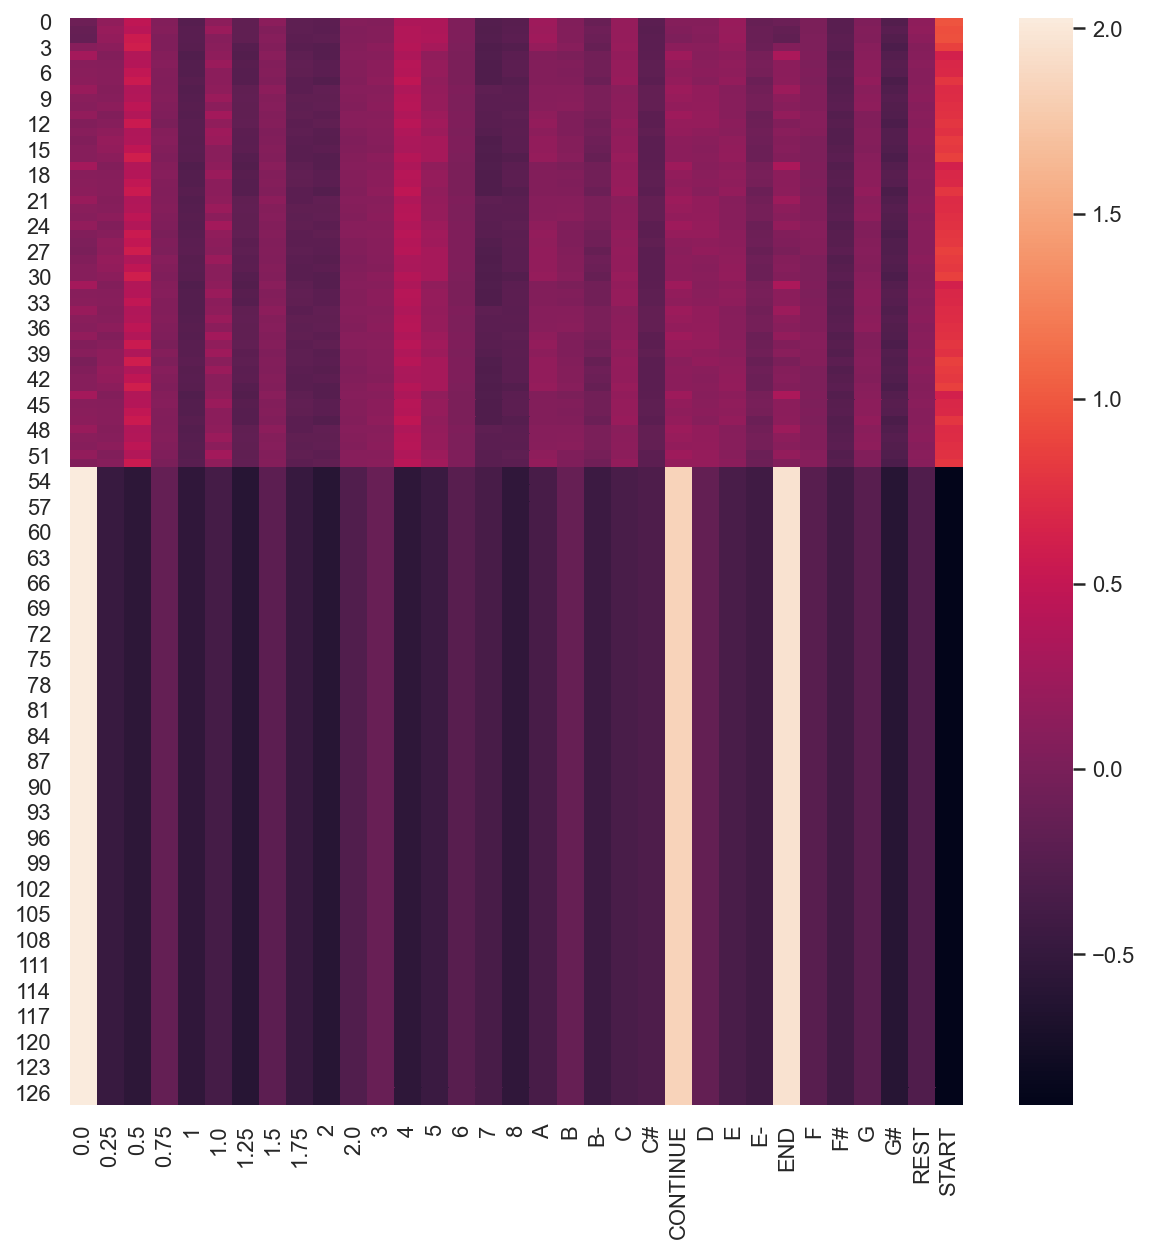

In [114]:
plt.figure(figsize=(10, 10))
sns.heatmap(predictions, xticklabels=targets_vectorizer.get_feature_names())

In [108]:
predictions

array([[-0.08374591,  0.15158473,  0.46945179, ..., -0.2677645 ,
         0.13849139,  0.9797471 ],
       [-0.12963006,  0.19889818,  0.42798626, ..., -0.22922294,
         0.15488884,  0.9491625 ],
       [-0.14751676,  0.18011004,  0.5616545 , ..., -0.27274138,
         0.12218828,  0.9559241 ],
       ...,
       [ 2.0286117 , -0.4640079 , -0.5580368 , ..., -0.59845406,
        -0.2966448 , -0.9068467 ],
       [ 2.0286121 , -0.46400774, -0.55803686, ..., -0.5984541 ,
        -0.29664487, -0.9068467 ],
       [ 2.0286121 , -0.46400774, -0.55803686, ..., -0.5984541 ,
        -0.29664487, -0.9068467 ]], dtype=float32)